# Random Forest Model

Random Forests are a powerful and versatile machine learning algorithm with several advantages. Especially in the context of sales forecasting, Random Forests can capture complex, non-linear relationships between features (such as marketing spend, seasonality, and historical sales) and the target variable (future sales) effectively.

The benefit of using Random Forests is that predictions from multiple decision trees are aggregated, which helps reduce the risk of overfitting that can occur with single decision trees. This is particularly useful in sales forecasting where overfitting to historical data can lead to poor generalization to new data.

The ease of use of Random Forests also comes from the fact that almost no additional data preprocessing is necessary. The only transformation needed is to one-hot encode categorical variables into dummy variables.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

from sktime.transformations.series.summarize import WindowSummarizer

import pickle

In [ ]:
# for google colab
#!unrar x drive/MyDrive/sweet-spot-donut-sales-forecasting.rar

In [17]:
%run Function_scripts/functions_model.py
%run Function_scripts/functions_vis.py

In [18]:
pd.set_option("display.max_columns", None)

### Loading the dataset

In [6]:
d = pd.read_csv("data/train_df.csv", parse_dates=[0])
d_test = pd.read_csv("data/test_df.csv", parse_dates = [0])

In [7]:
d['date'] = pd.to_datetime(d['date'])
d_test['date'] = pd.to_datetime(d_test['date'])

## Modelling
#### Selecting and defining features

The following features were selected to be included in the baseline model:

* Item Category
* Store
* Weather
    * Temperature
    * Precipitation
    * Sunshine duration
* Time variables:
    * Timestep (number of days since the first recorded sale)
    * Day of the year
    * Weekday
    * Week of the year
    * Month
    * Year
* Window variables
    * Lagged features
    * Rolling averages
    * Rolling standard deviation
* Special events
    * New Year's Eve
    * Halloween
    * Valentine's Day
* Public Space dummy variable
* Public holidays
* School holidays
* Street market dummy variable

In [8]:
date = ["date"]

numfeat =["days_back","temperature_2m_mean","sunshine_duration","precipitation_hours"]

catfeat = ["store_name","item_category", 'day', 'halloween', 'hol_pub', "hol_school", 'month', 'nye', 'public_space', 'street_market', 'valentines_day','week_year', 'weekday', 'year']

In [9]:
d2 = d[date + catfeat + numfeat + ["total_amount"]]
d_test2 = d_test[date + catfeat + numfeat + ["total_amount"]]

In [10]:
agg_columns = d2.columns.difference(['date', 'store_name', 'item_category'] + ["total_amount"])
agg_dict = {col: "first" for col in agg_columns}
agg_dict["total_amount"] = "sum"

d2 = d2.groupby(['date', 'store_name', 'item_category']).agg(agg_dict).reset_index().sort_values(by = "date", ascending = False).reset_index(drop = True)
d2["hol_pub"] = d2["hol_pub"].apply(np.int64)

d2 = d2.set_index(["store_name","item_category","date"]).sort_index()

d_test2 = d_test2.groupby(['date', 'store_name', 'item_category']).agg(agg_dict).reset_index().sort_values(by = "date", ascending = False).reset_index(drop = True)
d_test2["hol_pub"] = d_test2["hol_pub"].apply(np.int64)

d_test2 = d_test2.set_index(["store_name","item_category","date"]).sort_index()

In [11]:
kwargs = {"lag_feature": {
    "lag":[1,2,3],
    "mean": [[1,7], [1, 15], [1,30]],
    "std": [[1,4]]
    },
    "target_cols":["total_amount"]}

transformer = WindowSummarizer(**kwargs, n_jobs= -1)

In [19]:
d2wind = transformer.fit_transform(d2)
d2wind = pd.concat([d2["total_amount"], d2wind], axis = 1).dropna()

### Transforming features

In order for the algorithm to work properly, some additional feature preprocessing is necessary. For Random Forest methods, this only includes one-hot-encoding categorical features.

In [20]:
cat_tr =Pipeline(steps=[
  ("ohe", OneHotEncoder(drop='first',sparse_output=False))
])

In [21]:
prepro =ColumnTransformer(
  transformers=[
    ("cat",cat_tr,catfeat)
    ],
    remainder ='passthrough'

    )

In [24]:
seed = 21

rf =Pipeline(
  steps=[
    ("prepro", prepro),
    ("rf",RandomForestRegressor(random_state = seed, verbose = 1, split_criterion="poisson"))])

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


In [22]:
xtrain = d2wind.reset_index().drop("total_amount", axis = 1).set_index("date")
ytrain = d2wind.reset_index()[["date","total_amount"]].set_index("date")

### Model fit and prediction

**Time-series cross-validation**

When performing k-fold cross-validation in a time-series context, the data musn't be shuffled as in a regular cross-validation scenario. Instead, a forecasting horizon has to be defined for each fold, which serves as the validation set. It always comes after the training set chronologically. Because predicting donut sales for more than one week in advance is a difficult endeavor and will most likely lead to imprecise results, the forecasting horizon for this problem was set to 7 days.

For more information, please refer to the notebook with the Catboost model.

In [27]:
tscv = create_train_validation_folds(xtrain.reset_index())

**Hyperparameter tuning**

Given that the Random Forest algorithm is a tree-based method, there are several hyperparameters that can be tuned. For this task, the following hyperparameters were chosen:

* Number of trees (estimators)
* Tree depth
* Maximum number of features to be used in each tree
* Smallest number of data to be used in a leaf before a split is made
* Smallest number of data to end up in a final node

In [28]:
param={
  "rf__max_depth":np.arange(5,50,1),
  "rf__n_estimators":np.arange(50,500,10),
  "rf__min_samples_split":np.arange(4,10,1),
  "rf__min_samples_leaf":np.arange(2,10,1),
  "rf__max_features": ["sqrt","log2"]
  }

rfh =RandomizedSearchCV(estimator= rf, param_distributions = param, refit = "neg_root_mean_squared_error", verbose = 1,
      scoring = ["neg_root_mean_squared_error","r2",'neg_mean_absolute_percentage_error'], cv=tscv, n_jobs = -1, n_iter = 20)


In [29]:
rfh.fit(xtrain, ytrain)

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Exception ignored in: <cyfunction RandomForestRegressor.__del__ at 0x7cf30d154ee0>
Traceback (most recent call last):
  File "randomforestregressor.pyx", line 317, in cuml.ensemble.randomforestregressor.RandomForestRegressor.__del__
  File "randomforestregressor.pyx", line 321, in cuml.ensemble.randomforestregressor.RandomForestRegressor._reset_forest_data
  File "base.pyx", line 330, in cuml.internals.base.Base.__getattr__
AttributeError: rf_forest
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RandomizedSearchCV(cv=[(Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       41083, 41084, 41085, 41086, 41087, 41088, 41089, 41090, 41091, 41092],
      dtype='int64', length=39728),
                        Index([  535,   536,   537,   538,   539,   540,   541,  1105,  1106,  1107,
       ...
       40089, 40090, 40091, 41093, 41094, 41095, 41096, 41097, 41098, 41099],
      dtype='int64', length=280)),
                       (Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       41090, 41091, 41092, 41093, 41094, 41095...
                                        'rf__min_samples_split': array([4, 5, 6, 7, 8, 9]),
                                        'rf__n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300,
       310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430,
       440, 450, 460, 470, 480, 490])},
                   refit='neg_root_mean_squared_error',
                   scoring=['neg_root_mean_squared_error', 'r2',
                            'neg_mean_absolute_percentage_error'],
                   verbose=1)

In [30]:
pd.DataFrame(rfh.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,3.113267,0.804649,0.142301,0.081796,180,9,9,log2,8,"{'rf__n_estimators': 180, 'rf__min_samples_spl...",-257.481870,-167.046277,-177.506206,-172.735435,-176.299619,-190.213881,33.829892,19,0.701474,0.809055,0.793635,0.741072,0.776152,0.764277,0.038706,19,-0.894852,-0.788083,-0.827831,-1.647149,-0.937351,-1.019053,0.318282,19
1,16.550669,0.753015,1.368115,0.303288,420,8,5,sqrt,38,"{'rf__n_estimators': 420, 'rf__min_samples_spl...",-111.917600,-109.609181,-104.765685,-118.637738,-111.316088,-111.249258,4.466931,3,0.943599,0.917789,0.928114,0.877859,0.910759,0.915624,0.021878,3,-0.221480,-0.267350,-0.269591,-0.525766,-0.279287,-0.312695,0.108397,4
2,5.224616,0.433482,0.061643,0.015906,440,9,4,log2,6,"{'rf__n_estimators': 440, 'rf__min_samples_spl...",-286.787391,-196.022673,-207.186740,-191.965754,-200.880788,-216.568669,35.474612,20,0.629652,0.737066,0.718853,0.680210,0.709379,0.695032,0.037508,20,-1.078442,-0.966531,-1.032001,-1.978390,-1.146210,-1.240315,0.373675,20
3,2.613944,0.547150,0.348209,0.140018,120,9,6,log2,14,"{'rf__n_estimators': 120, 'rf__min_samples_spl...",-198.432993,-128.518303,-136.568806,-145.383804,-142.666621,-150.314105,24.747564,15,0.822697,0.886978,0.877845,0.816579,0.853413,0.851502,0.028304,15,-0.535710,-0.528655,-0.536676,-0.997713,-0.549348,-0.629620,0.184167,14
4,12.140493,0.288722,1.042048,0.341664,380,6,5,sqrt,24,"{'rf__n_estimators': 380, 'rf__min_samples_spl...",-114.000030,-110.913333,-106.099221,-119.819870,-112.889509,-112.744393,4.453564,4,0.941481,0.915821,0.926272,0.875412,0.908218,0.913441,0.022045,4,-0.229260,-0.272961,-0.274798,-0.532208,-0.283633,-0.318572,0.108475,5
5,11.466471,2.006602,1.939654,0.625609,350,8,2,sqrt,28,"{'rf__n_estimators': 350, 'rf__min_samples_spl...",-108.338075,-108.031239,-99.678494,-115.889859,-110.175000,-108.422533,5.204816,2,0.947149,0.920139,0.934925,0.883451,0.912579,0.919649,0.021680,2,-0.206464,-0.260847,-0.256427,-0.504880,-0.268874,-0.299498,0.104999,2
6,3.872958,1.036752,0.273921,0.071173,120,9,4,log2,39,"{'rf__n_estimators': 120, 'rf__min_samples_spl...",-148.759019,-106.883357,-110.300677,-130.285517,-123.940843,-124.033883,15.054338,10,0.900355,0.921827,0.920317,0.852698,0.889368,0.896913,0.025267,10,-0.294786,-0.336731,-0.335181,-0.680146,-0.357914,-0.400952,0.141084,10
7,2.798312,0.252783,0.256371,0.073190,80,4,5,sqrt,28,"{'rf__n_estimators': 80, 'rf__min_samples_spli...",-117.447331,-111.155723,-107.738588,-117.644273,-115.000862,-113.797355,3.827699,6,0.937888,0.915453,0.923976,0.879896,0.904753,0.912393,0.019534,6,-0.222419,-0.270531,-0.268770,-0.506710,-0.283535,-0.310393,0.100322,3
8,8.068881,0.247552,0.391165,0.121439,300,4,8,sqrt,20,"{'rf__n_estimators': 300, 'rf__min_samples_spl...",-124.156569,-110.101226,-108.675851,-121.993074,-117.167876,-116.418919,6.186626,8,0.930589,0.917050,0.922647,0.870852,0.901129,0.908453,0.021132,8,-0.255024,-0.285891,-0.298617,-0.558831,-0.300097,-0.339692,0.110761,8
9,7.857569,0.445142,0.423774,0.151640,230,6,8,sqrt,35,"{'rf__n_estimators': 23

In [25]:
best_params = {'n_estimators': 380,
 'min_samples_split': 7,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 35}

In [27]:
seed = 21

rf_best = Pipeline(
  steps=[
    ("prepro", prepro),
    ("rf",RandomForestRegressor(**best_params, random_state = seed, verbose = 1, n_jobs = -1, criterion="poisson"))])

In [31]:
#rf_best = rfh.best_estimator_

Pipeline(steps=[('prepro',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['store_name',
                                                   'item_category', 'day',
                                                   'halloween', 'hol_pub',
                                                   'hol_school', 'month', 'nye',
                                                   'public_space',
                                                   'street_market',
                                                   'valentines_day',
                                                   'week_year', 'weekday',
                                                   'year'])])),
                ('rf', RandomForestRegressor())])

In [28]:
rf_best.fit(xtrain, ytrain)

s:\Repos\sweet-spot-donut-sales-forecasting\.venv\Lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 380 out of 380 | elapsed:   11.8s finished


Pipeline(steps=[('prepro',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['store_name',
                                                   'item_category', 'day',
                                                   'halloween', 'hol_pub',
                                                   'hol_school', 'month', 'nye',
                                                   'public_space',
                                                   'street_market',
                                                   'valentines_day',
                                                   'week_year', 'weekday',
                                                   'year'])])),
                ('rf',
                 RandomForestRegressor(criterion='poisson', max_depth=35,
                                       max_features='sqrt', min_samples_leaf=2,
                                       min_samples_split=7, n_estimators=380,
                                       n_jobs=-1, random_state=21,
                                       verbose=1))])

In [29]:
ytrainpred = rf_best.predict(xtrain)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 380 out of 380 | elapsed:    0.7s finished


**Saving the model**

In [30]:
with open('saved_models/rf_best1.pkl', mode='wb') as file:
  pickle.dump(rf_best,file)

### Feature importances

In [101]:
feat_importances = pd.DataFrame({
    'Feature': rf_best.named_steps['prepro'].get_feature_names_out(),
    'Importance': rf_best.named_steps["rf"].feature_importances_
}).sort_values("Importance", ascending = False).head(20)

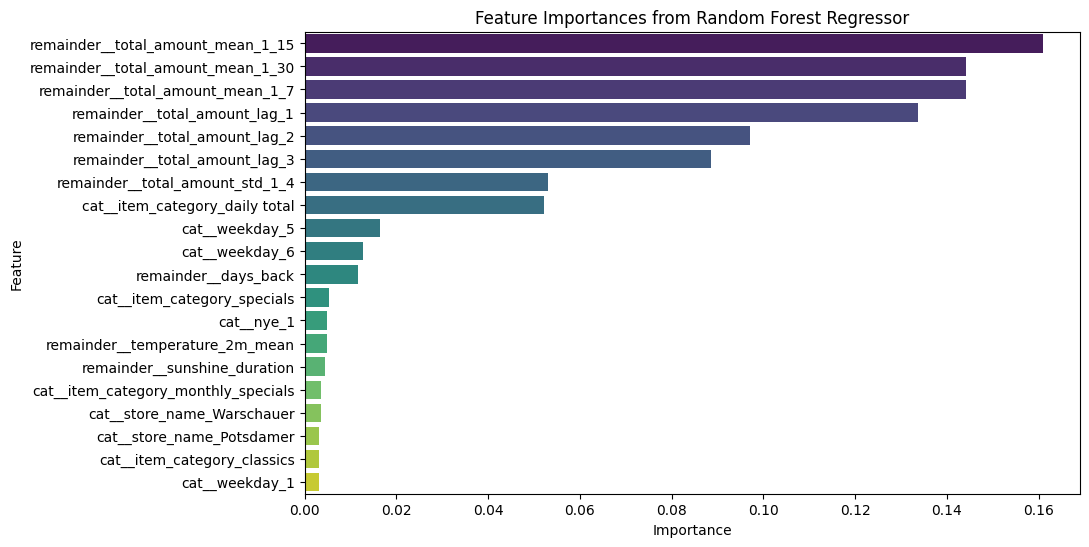

In [103]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances, palette='viridis')

plt.title('Feature Importances from Random Forest Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

The bar plot above shows the 20 most important features of the Random Forest model.

The most important features are by far the window variables. As a matter of fact, all seven window variables have the biggest impact in forecasting sales. Apart from that, the weekday variables - most notably Saturday and Sunday - are also good predictors of how many donuts will be sold on those days. The item category also plays a role, which reflects the fact that different consumers simply prefer different types of donuts. Other features are weaker predictors of donut sales.

### Evaluating the model with test data<br>

The first Random Forest predictions are made on the test dataset.

In [31]:
train_final = d2wind.iloc[d2wind.index.get_level_values("date") >= pd.to_datetime("2021-07-12")].reset_index().set_index("date")

xtest = d_test2.reset_index().set_index("date").drop("total_amount", axis = 1)
ytest = d_test2.reset_index()[["date","total_amount"]].set_index("date")

In [32]:
with open('saved_models/rf_best1.pkl', mode='rb') as file:
 rf_best = pickle.load(file)

In [ ]:
xtest_final, ytestpred = pred_test(train = train_final, test = xtest, model = rf_best)

### Fit statistics for train and test dataset

In [34]:
fit_overview(ytrain, ytrainpred, ytest, ytestpred)

R-squared train:  0.958
Mean absolute percentage error train:  19.0 

R-squared test  0.936
Mean absolute percentage error test:  22.0


The Random Forest model did better than the baseline model, with a **R-squared value of 0.94** and a **Mean Absolute Percentage Error (MAPE) of 22%**. The model's predictions are, on average, 26% over or under the actual sales. The results are further broken down into MAPE scores at the store and product category level.

In [41]:
mape_stores(d_test2, ytestpred, breakdown = "stores").sort_values("MAPE").reset_index(drop = True)

,Store name,MAPE
0,Jungfernstieg,12.196835
1,Potsdamer,16.474166
2,Maybachufer,18.329231
3,Warschauer,19.354114
4,Neuer Kamp,20.089734
5,Mitte,20.891636
6,Danziger,22.945416
7,Altona,45.299943


In [42]:
mape_stores(d_test2, ytestpred, breakdown = "stores_products").sort_values("MAPE").reset_index(drop = True)

,Store name,Product Category,MAPE
0,Maybachufer,monthly_specials,7.937609
1,Jungfernstieg,monthly_specials,8.044201
2,Jungfernstieg,daily total,9.565134
3,Jungfernstieg,specials,9.891145
4,Maybachufer,classics,10.979135
5,Maybachufer,daily total,11.317393
6,Jungfernstieg,mixed,13.403568
7,Mitte,monthly_specials,13.680854
8,Potsdamer,classics,14.136860
9,Potsdamer,daily total,14.366634


While some stores and store-product combinations were predicted relatively well and their MAPE scores are low, other stores and products don't exhibit such good results. For an ensemble-based model, the forecasted sales are solid, but can certainly be improved upon. This is especially true for those store-product combinations with a MAPE of over 30%.

Other models, especially methods relying on gradient boosting, can be leveraged to improve upon the baseline model's predictions. This is further explored in the CatBoost notebook.

### Residual Plot Analysis

The residual plot below shows the difference between the predicted and actual sales. Residuals were standardized with a mean 0.

In [105]:
difference_df = diff_overview(data = d_test2, pred = ytestpred)

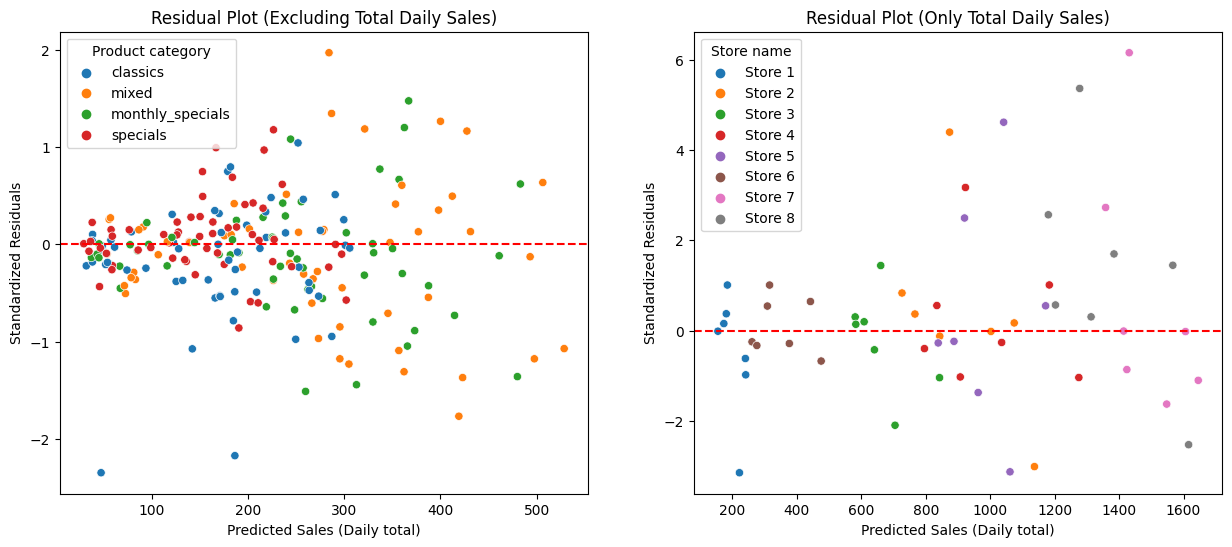

In [106]:
residual_plot(difference_df)

The first plot shows residuals excluding total daily sales. The second plot shows residuals with reference only to daily sales. The following observations can be made:

* The residuals for the different product categories seem normally distributed, with most of them being centered around the mean and within 1 standard deviation. 

* The product category plot seems to be rather heteroskedastic. Most notably, the mixed category - which sells boxes of different types of donuts - and monthly specials have relatively high residual errors, at least compared to other categories. Considering that most sold donuts belonged to the *mixed* category, it is no surprise that the model had difficulties predicting relatively high values correctly. The error distribution reveals that there may be some patterns in the dataset that the model didn't capture well enough and that could explain the sales trend. Another possibility is that some other variables - for example advertising or other special events - serve as better predictors for sales for these two categories. Alternatively, reclassfying the *mixed* group may yield a more precise represenatation of distinct donut categories that could individually explain sales better than the larger category.

* In the total daily sales plot, there are only a few points with low daily sales. These sales are from stores that opened recently. Apart from that, the plot looks more or less homoskedastic, meaning there are no clear patterns.

### Visualisation of predictions

In [108]:
df_predicted = pd.concat(
    [
    d2.reset_index()[(d2.reset_index()["date"] >= pd.to_datetime("2024-05-01"))][["date","store_name","item_category","total_amount"]],
    difference_df[["Date","Store name","Product category","Observed","Predicted"]].rename(columns = {"Date":"date","Store name":"store_name",
                                                                                                     "Product category":"item_category","Observed":"total_amount"})
    ]
    ).sort_values(["date","store_name","item_category"]).reset_index(drop = True)

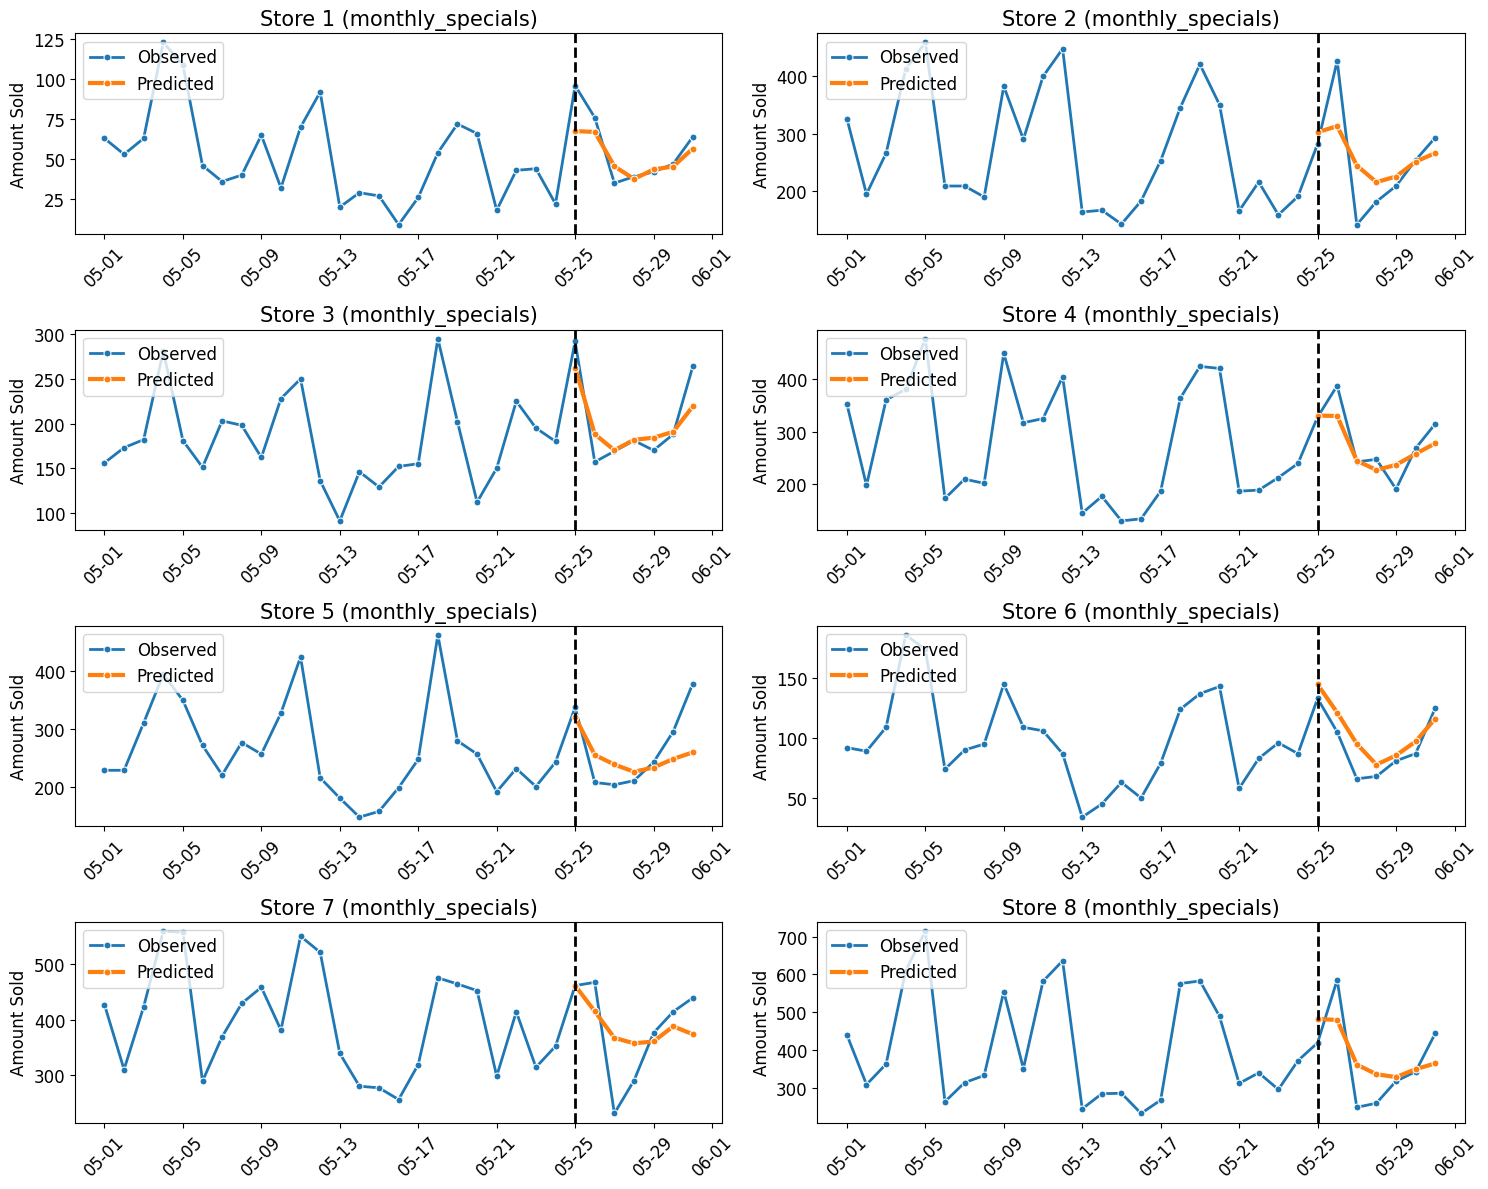

In [110]:
# specify item to view by product category: classics, mixed, monthly_specials, specials or daily total

ts_predicted(df_predicted, item = "monthly_specials")

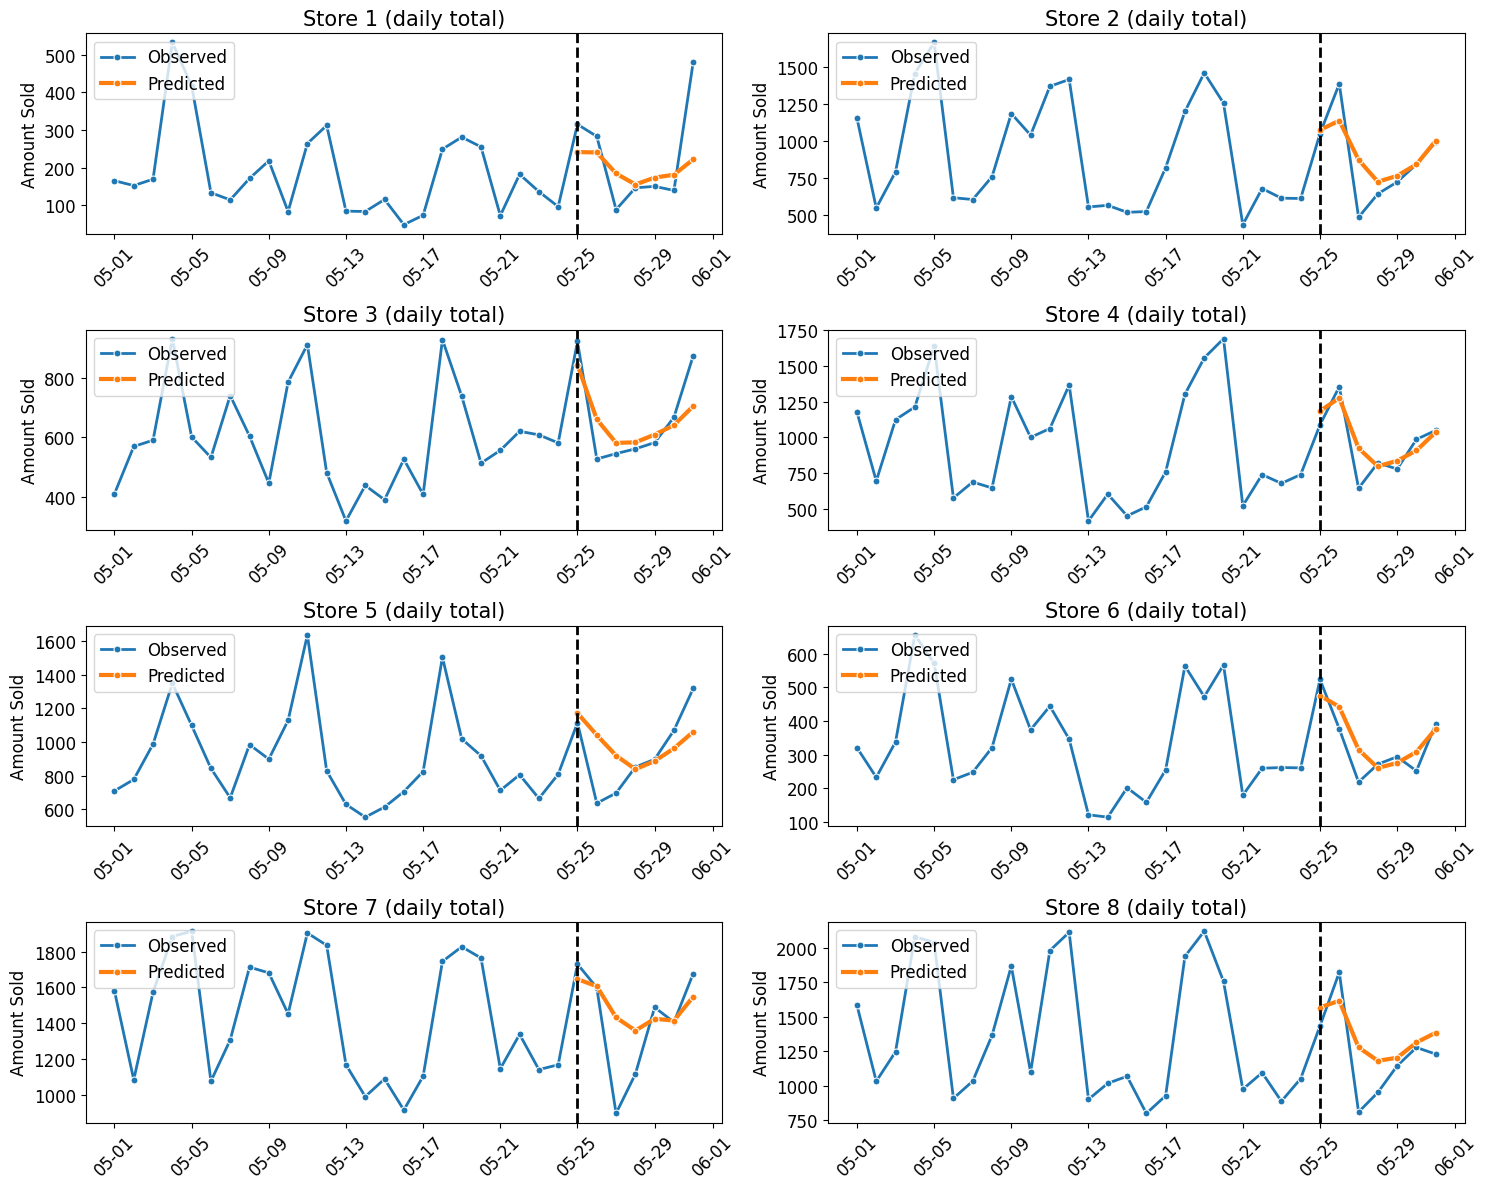

In [111]:
ts_predicted(df_predicted, item = "daily total")

Reflecting the MAPE scores of individual store-product pairs, the line charts show how precisely the Random Forest model could forecast sales. Some predictions are quite good for some store-product combinations, but fall short when it comes to forecasting sales for other stores and products. All in all, **only 12 of 40 store-product pairs have a MAPE of ~15%.** Ignoring the 3 stores that opened up recently, the highest MAPE scores are 35%, 34% and 32%. 

There are some noticable fluctuations in sales in all of May, yet certain patterns may still be observed. Still, the model is having difficulties identifying those sales patterns for the test time period between May 25 and May 31, 2024. It is therefore necessary to try predicting the sales with a Catboost model, a gradient boosting-based algorithm that should prove more capable of handling fluctuating sales.